In [6]:
!gsutil cp gs://chem_dsrc/AttentiveFP/AttentiveFP.zip ./
!unzip AttentiveFP.zip

Copying gs://chem_dsrc/AttentiveFP/AttentiveFP.zip...
/ [1 files][ 14.5 KiB/ 14.5 KiB]                                                
Operation completed over 1 objects/14.5 KiB.                                     
Archive:  AttentiveFP.zip
  inflating: AttentiveFP/__init__.py  
  inflating: AttentiveFP/AttentiveLayers.py  
  inflating: AttentiveFP/AttentiveLayers_viz.py  
  inflating: AttentiveFP/Featurizer.py  
  inflating: AttentiveFP/Featurizer_aromaticity_rm.py  
  inflating: AttentiveFP/getFeatures.py  
  inflating: AttentiveFP/getFeatures_aromaticity_rm.py  


In [19]:
!gsutil cp gs://chem_dsrc/AttentiveFP/data.zip ./
!unzip data.zip

Copying gs://chem_dsrc/AttentiveFP/data.zip...
- [1 files][ 17.0 MiB/ 17.0 MiB]                                                
Operation completed over 1 objects/17.0 MiB.                                     
Archive:  data.zip
  inflating: data/aromatic_adversarial.csv  
  inflating: data/aromatic_adversarial.pickle  
  inflating: data/aromatic_atom_count.csv  
  inflating: data/bace.csv           
  inflating: data/BBBP.csv           
  inflating: data/cep-processed.csv  
  inflating: data/clintox.csv        
  inflating: data/delaney-processed.csv  
  inflating: data/HIV.csv            
  inflating: data/LICENSE            
  inflating: data/Lipophilicity.csv  
  inflating: data/malaria-processed.csv  
  inflating: data/muv.csv            
  inflating: data/qm9.csv            
  inflating: data/SAMPL.csv          
  inflating: data/sider.csv          
  inflating: data/tox21.csv          
  inflating: data/toxcast_data.csv   


In [8]:
!pip install kora -q
import kora.install.rdkit

     |████████████████████████████████| 61kB 5.6MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 


In [9]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [11]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

number of all smiles:  8597
not successfully processed smiles:  [F-][B+3]([F-])([F-])[F-].CC[N+]1(C)CCCC1
not successfully processed smiles:  [Na+].[Na+].F[Si--](F)(F)(F)(F)F
not successfully processed smiles:  [NH4+].[NH4+].F[Si--](F)(F)(F)(F)F
not successfully processed smiles:  O.O.O.O.O=C1O[Mg]2(OC(=O)C3=CC=CC=C3O2)OC2=CC=CC=C12
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
number of successfully processed smiles:  8578


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


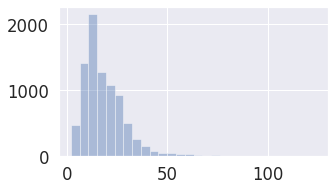

In [21]:
task_name = 'toxcast'
tasks = [
'ACEA_T47D_80hr_Negative','ACEA_T47D_80hr_Positive','APR_HepG2_CellCycleArrest_24h_dn','APR_HepG2_CellCycleArrest_24h_up','APR_HepG2_CellCycleArrest_72h_dn','APR_HepG2_CellLoss_24h_dn','APR_HepG2_CellLoss_72h_dn','APR_HepG2_MicrotubuleCSK_24h_dn','APR_HepG2_MicrotubuleCSK_24h_up','APR_HepG2_MicrotubuleCSK_72h_dn','APR_HepG2_MicrotubuleCSK_72h_up','APR_HepG2_MitoMass_24h_dn','APR_HepG2_MitoMass_24h_up','APR_HepG2_MitoMass_72h_dn','APR_HepG2_MitoMass_72h_up','APR_HepG2_MitoMembPot_1h_dn','APR_HepG2_MitoMembPot_24h_dn','APR_HepG2_MitoMembPot_72h_dn','APR_HepG2_MitoticArrest_24h_up','APR_HepG2_MitoticArrest_72h_up','APR_HepG2_NuclearSize_24h_dn','APR_HepG2_NuclearSize_72h_dn','APR_HepG2_NuclearSize_72h_up','APR_HepG2_OxidativeStress_24h_up','APR_HepG2_OxidativeStress_72h_up','APR_HepG2_StressKinase_1h_up','APR_HepG2_StressKinase_24h_up','APR_HepG2_StressKinase_72h_up','APR_HepG2_p53Act_24h_up','APR_HepG2_p53Act_72h_up','APR_Hepat_Apoptosis_24hr_up','APR_Hepat_Apoptosis_48hr_up','APR_Hepat_CellLoss_24hr_dn','APR_Hepat_CellLoss_48hr_dn','APR_Hepat_DNADamage_24hr_up','APR_Hepat_DNADamage_48hr_up','APR_Hepat_DNATexture_24hr_up','APR_Hepat_DNATexture_48hr_up','APR_Hepat_MitoFxnI_1hr_dn','APR_Hepat_MitoFxnI_24hr_dn','APR_Hepat_MitoFxnI_48hr_dn','APR_Hepat_NuclearSize_24hr_dn','APR_Hepat_NuclearSize_48hr_dn','APR_Hepat_Steatosis_24hr_up','APR_Hepat_Steatosis_48hr_up','ATG_AP_1_CIS_dn','ATG_AP_1_CIS_up','ATG_AP_2_CIS_dn','ATG_AP_2_CIS_up','ATG_AR_TRANS_dn','ATG_AR_TRANS_up','ATG_Ahr_CIS_dn','ATG_Ahr_CIS_up','ATG_BRE_CIS_dn','ATG_BRE_CIS_up','ATG_CAR_TRANS_dn','ATG_CAR_TRANS_up','ATG_CMV_CIS_dn','ATG_CMV_CIS_up','ATG_CRE_CIS_dn','ATG_CRE_CIS_up','ATG_C_EBP_CIS_dn','ATG_C_EBP_CIS_up','ATG_DR4_LXR_CIS_dn','ATG_DR4_LXR_CIS_up','ATG_DR5_CIS_dn','ATG_DR5_CIS_up','ATG_E2F_CIS_dn','ATG_E2F_CIS_up','ATG_EGR_CIS_up','ATG_ERE_CIS_dn','ATG_ERE_CIS_up','ATG_ERRa_TRANS_dn','ATG_ERRg_TRANS_dn','ATG_ERRg_TRANS_up','ATG_ERa_TRANS_up','ATG_E_Box_CIS_dn','ATG_E_Box_CIS_up','ATG_Ets_CIS_dn','ATG_Ets_CIS_up','ATG_FXR_TRANS_up','ATG_FoxA2_CIS_dn','ATG_FoxA2_CIS_up','ATG_FoxO_CIS_dn','ATG_FoxO_CIS_up','ATG_GAL4_TRANS_dn','ATG_GATA_CIS_dn','ATG_GATA_CIS_up','ATG_GLI_CIS_dn','ATG_GLI_CIS_up','ATG_GRE_CIS_dn','ATG_GRE_CIS_up','ATG_GR_TRANS_dn','ATG_GR_TRANS_up','ATG_HIF1a_CIS_dn','ATG_HIF1a_CIS_up','ATG_HNF4a_TRANS_dn','ATG_HNF4a_TRANS_up','ATG_HNF6_CIS_dn','ATG_HNF6_CIS_up','ATG_HSE_CIS_dn','ATG_HSE_CIS_up','ATG_IR1_CIS_dn','ATG_IR1_CIS_up','ATG_ISRE_CIS_dn','ATG_ISRE_CIS_up','ATG_LXRa_TRANS_dn','ATG_LXRa_TRANS_up','ATG_LXRb_TRANS_dn','ATG_LXRb_TRANS_up','ATG_MRE_CIS_up','ATG_M_06_TRANS_up','ATG_M_19_CIS_dn','ATG_M_19_TRANS_dn','ATG_M_19_TRANS_up','ATG_M_32_CIS_dn','ATG_M_32_CIS_up','ATG_M_32_TRANS_dn','ATG_M_32_TRANS_up','ATG_M_61_TRANS_up','ATG_Myb_CIS_dn','ATG_Myb_CIS_up','ATG_Myc_CIS_dn','ATG_Myc_CIS_up','ATG_NFI_CIS_dn','ATG_NFI_CIS_up','ATG_NF_kB_CIS_dn','ATG_NF_kB_CIS_up','ATG_NRF1_CIS_dn','ATG_NRF1_CIS_up','ATG_NRF2_ARE_CIS_dn','ATG_NRF2_ARE_CIS_up','ATG_NURR1_TRANS_dn','ATG_NURR1_TRANS_up','ATG_Oct_MLP_CIS_dn','ATG_Oct_MLP_CIS_up','ATG_PBREM_CIS_dn','ATG_PBREM_CIS_up','ATG_PPARa_TRANS_dn','ATG_PPARa_TRANS_up','ATG_PPARd_TRANS_up','ATG_PPARg_TRANS_up','ATG_PPRE_CIS_dn','ATG_PPRE_CIS_up','ATG_PXRE_CIS_dn','ATG_PXRE_CIS_up','ATG_PXR_TRANS_dn','ATG_PXR_TRANS_up','ATG_Pax6_CIS_up','ATG_RARa_TRANS_dn','ATG_RARa_TRANS_up','ATG_RARb_TRANS_dn','ATG_RARb_TRANS_up','ATG_RARg_TRANS_dn','ATG_RARg_TRANS_up','ATG_RORE_CIS_dn','ATG_RORE_CIS_up','ATG_RORb_TRANS_dn','ATG_RORg_TRANS_dn','ATG_RORg_TRANS_up','ATG_RXRa_TRANS_dn','ATG_RXRa_TRANS_up','ATG_RXRb_TRANS_dn','ATG_RXRb_TRANS_up','ATG_SREBP_CIS_dn','ATG_SREBP_CIS_up','ATG_STAT3_CIS_dn','ATG_STAT3_CIS_up','ATG_Sox_CIS_dn','ATG_Sox_CIS_up','ATG_Sp1_CIS_dn','ATG_Sp1_CIS_up','ATG_TAL_CIS_dn','ATG_TAL_CIS_up','ATG_TA_CIS_dn','ATG_TA_CIS_up','ATG_TCF_b_cat_CIS_dn','ATG_TCF_b_cat_CIS_up','ATG_TGFb_CIS_dn','ATG_TGFb_CIS_up','ATG_THRa1_TRANS_dn','ATG_THRa1_TRANS_up','ATG_VDRE_CIS_dn','ATG_VDRE_CIS_up','ATG_VDR_TRANS_dn','ATG_VDR_TRANS_up','ATG_XTT_Cytotoxicity_up','ATG_Xbp1_CIS_dn','ATG_Xbp1_CIS_up','ATG_p53_CIS_dn','ATG_p53_CIS_up','BSK_3C_Eselectin_down','BSK_3C_HLADR_down','BSK_3C_ICAM1_down','BSK_3C_IL8_down','BSK_3C_MCP1_down','BSK_3C_MIG_down','BSK_3C_Proliferation_down','BSK_3C_SRB_down','BSK_3C_Thrombomodulin_down','BSK_3C_Thrombomodulin_up','BSK_3C_TissueFactor_down','BSK_3C_TissueFactor_up','BSK_3C_VCAM1_down','BSK_3C_Vis_down','BSK_3C_uPAR_down','BSK_4H_Eotaxin3_down','BSK_4H_MCP1_down','BSK_4H_Pselectin_down','BSK_4H_Pselectin_up','BSK_4H_SRB_down','BSK_4H_VCAM1_down','BSK_4H_VEGFRII_down','BSK_4H_uPAR_down','BSK_4H_uPAR_up','BSK_BE3C_HLADR_down','BSK_BE3C_IL1a_down','BSK_BE3C_IP10_down','BSK_BE3C_MIG_down','BSK_BE3C_MMP1_down','BSK_BE3C_MMP1_up','BSK_BE3C_PAI1_down','BSK_BE3C_SRB_down','BSK_BE3C_TGFb1_down','BSK_BE3C_tPA_down','BSK_BE3C_uPAR_down','BSK_BE3C_uPAR_up','BSK_BE3C_uPA_down','BSK_CASM3C_HLADR_down','BSK_CASM3C_IL6_down','BSK_CASM3C_IL6_up','BSK_CASM3C_IL8_down','BSK_CASM3C_LDLR_down','BSK_CASM3C_LDLR_up','BSK_CASM3C_MCP1_down','BSK_CASM3C_MCP1_up','BSK_CASM3C_MCSF_down','BSK_CASM3C_MCSF_up','BSK_CASM3C_MIG_down','BSK_CASM3C_Proliferation_down','BSK_CASM3C_Proliferation_up','BSK_CASM3C_SAA_down','BSK_CASM3C_SAA_up','BSK_CASM3C_SRB_down','BSK_CASM3C_Thrombomodulin_down','BSK_CASM3C_Thrombomodulin_up','BSK_CASM3C_TissueFactor_down','BSK_CASM3C_VCAM1_down','BSK_CASM3C_VCAM1_up','BSK_CASM3C_uPAR_down','BSK_CASM3C_uPAR_up','BSK_KF3CT_ICAM1_down','BSK_KF3CT_IL1a_down','BSK_KF3CT_IP10_down','BSK_KF3CT_IP10_up','BSK_KF3CT_MCP1_down','BSK_KF3CT_MCP1_up','BSK_KF3CT_MMP9_down','BSK_KF3CT_SRB_down','BSK_KF3CT_TGFb1_down','BSK_KF3CT_TIMP2_down','BSK_KF3CT_uPA_down','BSK_LPS_CD40_down','BSK_LPS_Eselectin_down','BSK_LPS_Eselectin_up','BSK_LPS_IL1a_down','BSK_LPS_IL1a_up','BSK_LPS_IL8_down','BSK_LPS_IL8_up','BSK_LPS_MCP1_down','BSK_LPS_MCSF_down','BSK_LPS_PGE2_down','BSK_LPS_PGE2_up','BSK_LPS_SRB_down','BSK_LPS_TNFa_down','BSK_LPS_TNFa_up','BSK_LPS_TissueFactor_down','BSK_LPS_TissueFactor_up','BSK_LPS_VCAM1_down','BSK_SAg_CD38_down','BSK_SAg_CD40_down','BSK_SAg_CD69_down','BSK_SAg_Eselectin_down','BSK_SAg_Eselectin_up','BSK_SAg_IL8_down','BSK_SAg_IL8_up','BSK_SAg_MCP1_down','BSK_SAg_MIG_down','BSK_SAg_PBMCCytotoxicity_down','BSK_SAg_PBMCCytotoxicity_up','BSK_SAg_Proliferation_down','BSK_SAg_SRB_down','BSK_hDFCGF_CollagenIII_down','BSK_hDFCGF_EGFR_down','BSK_hDFCGF_EGFR_up','BSK_hDFCGF_IL8_down','BSK_hDFCGF_IP10_down','BSK_hDFCGF_MCSF_down','BSK_hDFCGF_MIG_down','BSK_hDFCGF_MMP1_down','BSK_hDFCGF_MMP1_up','BSK_hDFCGF_PAI1_down','BSK_hDFCGF_Proliferation_down','BSK_hDFCGF_SRB_down','BSK_hDFCGF_TIMP1_down','BSK_hDFCGF_VCAM1_down','CEETOX_H295R_11DCORT_dn','CEETOX_H295R_ANDR_dn','CEETOX_H295R_CORTISOL_dn','CEETOX_H295R_DOC_dn','CEETOX_H295R_DOC_up','CEETOX_H295R_ESTRADIOL_dn','CEETOX_H295R_ESTRADIOL_up','CEETOX_H295R_ESTRONE_dn','CEETOX_H295R_ESTRONE_up','CEETOX_H295R_OHPREG_up','CEETOX_H295R_OHPROG_dn','CEETOX_H295R_OHPROG_up','CEETOX_H295R_PROG_up','CEETOX_H295R_TESTO_dn','CLD_ABCB1_48hr','CLD_ABCG2_48hr','CLD_CYP1A1_24hr','CLD_CYP1A1_48hr','CLD_CYP1A1_6hr','CLD_CYP1A2_24hr','CLD_CYP1A2_48hr','CLD_CYP1A2_6hr','CLD_CYP2B6_24hr','CLD_CYP2B6_48hr','CLD_CYP2B6_6hr','CLD_CYP3A4_24hr','CLD_CYP3A4_48hr','CLD_CYP3A4_6hr','CLD_GSTA2_48hr','CLD_SULT2A_24hr','CLD_SULT2A_48hr','CLD_UGT1A1_24hr','CLD_UGT1A1_48hr','NCCT_HEK293T_CellTiterGLO','NCCT_QuantiLum_inhib_2_dn','NCCT_QuantiLum_inhib_dn','NCCT_TPO_AUR_dn','NCCT_TPO_GUA_dn','NHEERL_ZF_144hpf_TERATOSCORE_up','NVS_ADME_hCYP19A1','NVS_ADME_hCYP1A1','NVS_ADME_hCYP1A2','NVS_ADME_hCYP2A6','NVS_ADME_hCYP2B6','NVS_ADME_hCYP2C19','NVS_ADME_hCYP2C9','NVS_ADME_hCYP2D6','NVS_ADME_hCYP3A4','NVS_ADME_hCYP4F12','NVS_ADME_rCYP2C12','NVS_ENZ_hAChE','NVS_ENZ_hAMPKa1','NVS_ENZ_hAurA','NVS_ENZ_hBACE','NVS_ENZ_hCASP5','NVS_ENZ_hCK1D','NVS_ENZ_hDUSP3','NVS_ENZ_hES','NVS_ENZ_hElastase','NVS_ENZ_hFGFR1','NVS_ENZ_hGSK3b','NVS_ENZ_hMMP1','NVS_ENZ_hMMP13','NVS_ENZ_hMMP2','NVS_ENZ_hMMP3','NVS_ENZ_hMMP7','NVS_ENZ_hMMP9','NVS_ENZ_hPDE10','NVS_ENZ_hPDE4A1','NVS_ENZ_hPDE5','NVS_ENZ_hPI3Ka','NVS_ENZ_hPTEN','NVS_ENZ_hPTPN11','NVS_ENZ_hPTPN12','NVS_ENZ_hPTPN13','NVS_ENZ_hPTPN9','NVS_ENZ_hPTPRC','NVS_ENZ_hSIRT1','NVS_ENZ_hSIRT2','NVS_ENZ_hTrkA','NVS_ENZ_hVEGFR2','NVS_ENZ_oCOX1','NVS_ENZ_oCOX2','NVS_ENZ_rAChE','NVS_ENZ_rCNOS','NVS_ENZ_rMAOAC','NVS_ENZ_rMAOAP','NVS_ENZ_rMAOBC','NVS_ENZ_rMAOBP','NVS_ENZ_rabI2C','NVS_GPCR_bAdoR_NonSelective','NVS_GPCR_bDR_NonSelective','NVS_GPCR_g5HT4','NVS_GPCR_gH2','NVS_GPCR_gLTB4','NVS_GPCR_gLTD4','NVS_GPCR_gMPeripheral_NonSelective','NVS_GPCR_gOpiateK','NVS_GPCR_h5HT2A','NVS_GPCR_h5HT5A','NVS_GPCR_h5HT6','NVS_GPCR_h5HT7','NVS_GPCR_hAT1','NVS_GPCR_hAdoRA1','NVS_GPCR_hAdoRA2a','NVS_GPCR_hAdra2A','NVS_GPCR_hAdra2C','NVS_GPCR_hAdrb1','NVS_GPCR_hAdrb2','NVS_GPCR_hAdrb3','NVS_GPCR_hDRD1','NVS_GPCR_hDRD2s','NVS_GPCR_hDRD4.4','NVS_GPCR_hH1','NVS_GPCR_hLTB4_BLT1','NVS_GPCR_hM1','NVS_GPCR_hM2','NVS_GPCR_hM3','NVS_GPCR_hM4','NVS_GPCR_hNK2','NVS_GPCR_hOpiate_D1','NVS_GPCR_hOpiate_mu','NVS_GPCR_hTXA2','NVS_GPCR_p5HT2C','NVS_GPCR_r5HT1_NonSelective','NVS_GPCR_r5HT_NonSelective','NVS_GPCR_rAdra1B','NVS_GPCR_rAdra1_NonSelective','NVS_GPCR_rAdra2_NonSelective','NVS_GPCR_rAdrb_NonSelective','NVS_GPCR_rNK1','NVS_GPCR_rNK3','NVS_GPCR_rOpiate_NonSelective','NVS_GPCR_rOpiate_NonSelectiveNa','NVS_GPCR_rSST','NVS_GPCR_rTRH','NVS_GPCR_rV1','NVS_GPCR_rabPAF','NVS_GPCR_rmAdra2B','NVS_IC_hKhERGCh','NVS_IC_rCaBTZCHL','NVS_IC_rCaDHPRCh_L','NVS_IC_rNaCh_site2','NVS_LGIC_bGABARa1','NVS_LGIC_h5HT3','NVS_LGIC_hNNR_NBungSens','NVS_LGIC_rGABAR_NonSelective','NVS_LGIC_rNNR_BungSens','NVS_MP_hPBR','NVS_MP_rPBR','NVS_NR_bER','NVS_NR_bPR','NVS_NR_cAR','NVS_NR_hAR','NVS_NR_hCAR_Antagonist','NVS_NR_hER','NVS_NR_hFXR_Agonist','NVS_NR_hFXR_Antagonist','NVS_NR_hGR','NVS_NR_hPPARa','NVS_NR_hPPARg','NVS_NR_hPR','NVS_NR_hPXR','NVS_NR_hRAR_Antagonist','NVS_NR_hRARa_Agonist','NVS_NR_hTRa_Antagonist','NVS_NR_mERa','NVS_NR_rAR','NVS_NR_rMR','NVS_OR_gSIGMA_NonSelective','NVS_TR_gDAT','NVS_TR_hAdoT','NVS_TR_hDAT','NVS_TR_hNET','NVS_TR_hSERT','NVS_TR_rNET','NVS_TR_rSERT','NVS_TR_rVMAT2','OT_AR_ARELUC_AG_1440','OT_AR_ARSRC1_0480','OT_AR_ARSRC1_0960','OT_ER_ERaERa_0480','OT_ER_ERaERa_1440','OT_ER_ERaERb_0480','OT_ER_ERaERb_1440','OT_ER_ERbERb_0480','OT_ER_ERbERb_1440','OT_ERa_EREGFP_0120','OT_ERa_EREGFP_0480','OT_FXR_FXRSRC1_0480','OT_FXR_FXRSRC1_1440','OT_NURR1_NURR1RXRa_0480','OT_NURR1_NURR1RXRa_1440','TOX21_ARE_BLA_Agonist_ch1','TOX21_ARE_BLA_Agonist_ch2','TOX21_ARE_BLA_agonist_ratio','TOX21_ARE_BLA_agonist_viability','TOX21_AR_BLA_Agonist_ch1','TOX21_AR_BLA_Agonist_ch2','TOX21_AR_BLA_Agonist_ratio','TOX21_AR_BLA_Antagonist_ch1','TOX21_AR_BLA_Antagonist_ch2','TOX21_AR_BLA_Antagonist_ratio','TOX21_AR_BLA_Antagonist_viability','TOX21_AR_LUC_MDAKB2_Agonist','TOX21_AR_LUC_MDAKB2_Antagonist','TOX21_AR_LUC_MDAKB2_Antagonist2','TOX21_AhR_LUC_Agonist','TOX21_Aromatase_Inhibition','TOX21_AutoFluor_HEK293_Cell_blue','TOX21_AutoFluor_HEK293_Media_blue','TOX21_AutoFluor_HEPG2_Cell_blue','TOX21_AutoFluor_HEPG2_Cell_green','TOX21_AutoFluor_HEPG2_Media_blue','TOX21_AutoFluor_HEPG2_Media_green','TOX21_ELG1_LUC_Agonist','TOX21_ERa_BLA_Agonist_ch1','TOX21_ERa_BLA_Agonist_ch2','TOX21_ERa_BLA_Agonist_ratio','TOX21_ERa_BLA_Antagonist_ch1','TOX21_ERa_BLA_Antagonist_ch2','TOX21_ERa_BLA_Antagonist_ratio','TOX21_ERa_BLA_Antagonist_viability','TOX21_ERa_LUC_BG1_Agonist','TOX21_ERa_LUC_BG1_Antagonist','TOX21_ESRE_BLA_ch1','TOX21_ESRE_BLA_ch2','TOX21_ESRE_BLA_ratio','TOX21_ESRE_BLA_viability','TOX21_FXR_BLA_Antagonist_ch1','TOX21_FXR_BLA_Antagonist_ch2','TOX21_FXR_BLA_agonist_ch2','TOX21_FXR_BLA_agonist_ratio','TOX21_FXR_BLA_antagonist_ratio','TOX21_FXR_BLA_antagonist_viability','TOX21_GR_BLA_Agonist_ch1','TOX21_GR_BLA_Agonist_ch2','TOX21_GR_BLA_Agonist_ratio','TOX21_GR_BLA_Antagonist_ch2','TOX21_GR_BLA_Antagonist_ratio','TOX21_GR_BLA_Antagonist_viability','TOX21_HSE_BLA_agonist_ch1','TOX21_HSE_BLA_agonist_ch2','TOX21_HSE_BLA_agonist_ratio','TOX21_HSE_BLA_agonist_viability','TOX21_MMP_ratio_down','TOX21_MMP_ratio_up','TOX21_MMP_viability','TOX21_NFkB_BLA_agonist_ch1','TOX21_NFkB_BLA_agonist_ch2','TOX21_NFkB_BLA_agonist_ratio','TOX21_NFkB_BLA_agonist_viability','TOX21_PPARd_BLA_Agonist_viability','TOX21_PPARd_BLA_Antagonist_ch1','TOX21_PPARd_BLA_agonist_ch1','TOX21_PPARd_BLA_agonist_ch2','TOX21_PPARd_BLA_agonist_ratio','TOX21_PPARd_BLA_antagonist_ratio','TOX21_PPARd_BLA_antagonist_viability','TOX21_PPARg_BLA_Agonist_ch1','TOX21_PPARg_BLA_Agonist_ch2','TOX21_PPARg_BLA_Agonist_ratio','TOX21_PPARg_BLA_Antagonist_ch1','TOX21_PPARg_BLA_antagonist_ratio','TOX21_PPARg_BLA_antagonist_viability','TOX21_TR_LUC_GH3_Agonist','TOX21_TR_LUC_GH3_Antagonist','TOX21_VDR_BLA_Agonist_viability','TOX21_VDR_BLA_Antagonist_ch1','TOX21_VDR_BLA_agonist_ch2','TOX21_VDR_BLA_agonist_ratio','TOX21_VDR_BLA_antagonist_ratio','TOX21_VDR_BLA_antagonist_viability','TOX21_p53_BLA_p1_ch1','TOX21_p53_BLA_p1_ch2','TOX21_p53_BLA_p1_ratio','TOX21_p53_BLA_p1_viability','TOX21_p53_BLA_p2_ch1','TOX21_p53_BLA_p2_ch2','TOX21_p53_BLA_p2_ratio','TOX21_p53_BLA_p2_viability','TOX21_p53_BLA_p3_ch1','TOX21_p53_BLA_p3_ch2','TOX21_p53_BLA_p3_ratio','TOX21_p53_BLA_p3_viability','TOX21_p53_BLA_p4_ch1','TOX21_p53_BLA_p4_ch2','TOX21_p53_BLA_p4_ratio','TOX21_p53_BLA_p4_viability','TOX21_p53_BLA_p5_ch1','TOX21_p53_BLA_p5_ch2','TOX21_p53_BLA_p5_ratio','TOX21_p53_BLA_p5_viability','Tanguay_ZF_120hpf_AXIS_up','Tanguay_ZF_120hpf_ActivityScore','Tanguay_ZF_120hpf_BRAI_up','Tanguay_ZF_120hpf_CFIN_up','Tanguay_ZF_120hpf_CIRC_up','Tanguay_ZF_120hpf_EYE_up','Tanguay_ZF_120hpf_JAW_up','Tanguay_ZF_120hpf_MORT_up','Tanguay_ZF_120hpf_OTIC_up','Tanguay_ZF_120hpf_PE_up','Tanguay_ZF_120hpf_PFIN_up','Tanguay_ZF_120hpf_PIG_up','Tanguay_ZF_120hpf_SNOU_up','Tanguay_ZF_120hpf_SOMI_up','Tanguay_ZF_120hpf_SWIM_up','Tanguay_ZF_120hpf_TRUN_up','Tanguay_ZF_120hpf_TR_up','Tanguay_ZF_120hpf_YSE_up'
]
raw_filename = "./data/toxcast_data.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [23]:
random_seed = 888
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.5
fingerprint_dim = 200

radius = 3
T = 3
weight_decay = 3 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [24]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<151]
uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>150]

smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

[Ca+2].[Cl-].[Cl-]
[Cd+2].[Cl-].[Cl-]
CC[n+]1ccccc1.F[P-](F)(F)(F)(F)F
O.O.[Ba+2].[Cl-].[Cl-]
CC[N+]1(C)CCCC1.F[P-](F)(F)(F)(F)F
N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O.O.O.[Na+].[Na+]
CCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCC[n+]1ccccc1.F[P-](F)(F)(F)(F)F
CCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCCCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCCCCCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCCCCCCCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCn1cc[n+](C)c1C.F[P-](F)(F)(F)(F)F
CCn1cc[n+](C)c1C.F[P-](F)(F)(F)(F)F
CCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCC[N+]1(C)CCCC1.F[P-](F)(F)(F)(F)F
CCCC[N+]1(C)CCCC1.F[P-](F)(F)(F)(F)F
CCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
CCCCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC.F[P-](F)(F)(F)(F)F
CCCC[n+]1ccc(C)cc1.F[P-](F)(F)(F)(F)F
[Cl-].[Cl-].[Cu+2]
[Cl-].[Cl-].[Hg+2]
[Br-].[Na+]
[I-].[K+]
[Cl-].[Cl-].[Cl-].[Fe+3]
[Cl-].[Cl-].[Fe+2]
[Cl-].[Cl-].[Sn

,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,APR_HepG2_MicrotubuleCSK_72h_dn,APR_HepG2_MicrotubuleCSK_72h_up,APR_HepG2_MitoMass_24h_dn,APR_HepG2_MitoMass_24h_up,APR_HepG2_MitoMass_72h_dn,APR_HepG2_MitoMass_72h_up,APR_HepG2_MitoMembPot_1h_dn,APR_HepG2_MitoMembPot_24h_dn,APR_HepG2_MitoMembPot_72h_dn,APR_HepG2_MitoticArrest_24h_up,APR_HepG2_MitoticArrest_72h_up,APR_HepG2_NuclearSize_24h_dn,APR_HepG2_NuclearSize_72h_dn,APR_HepG2_NuclearSize_72h_up,APR_HepG2_OxidativeStress_24h_up,APR_HepG2_OxidativeStress_72h_up,APR_HepG2_StressKinase_1h_up,APR_HepG2_StressKinase_24h_up,APR_HepG2_StressKinase_72h_up,APR_HepG2_p53Act_24h_up,APR_HepG2_p53Act_72h_up,APR_Hepat_Apoptosis_24hr_up,APR_Hepat_Apoptosis_48hr_up,APR_Hepat_CellLoss_24hr_dn,APR_Hepat_CellLoss_48hr_dn,APR_Hepat_DNADamage_24hr_up,APR_Hepat_DNADamage_48hr_up,APR_Hepat_DNATexture_24hr_up,APR_Hepat_DNATexture_48hr_up,APR_Hepat_MitoFxnI_1hr_dn,...,TOX21_VDR_BLA_antagonist_viability,TOX21_p53_BLA_p1_ch1,TOX21_p53_BLA_p1_ch2,TOX21_p53_BLA_p1_ratio,TOX21_p53_BLA_p1_viability,TOX21_p53_BLA_p2_ch1,TOX21_p53_BLA_p2_ch2,TOX21_p53_BLA_p2_ratio,TOX21_p53_BLA_p2_viability,TOX21_p53_BLA_p3_ch1,TOX21_p53_BLA_p3_ch2,TOX21_p53_BLA_p3_ratio,TOX21_p53_BLA_p3_viability,TOX21_p53_BLA_p4_ch1,TOX21_p53_BLA_p4_ch2,TOX21_p53_BLA_p4_ratio,TOX21_p53_BLA_p4_viability,TOX21_p53_BLA_p5_ch1,TOX21_p53_BLA_p5_ch2,TOX21_p53_BLA_p5_ratio,TOX21_p53_BLA_p5_viability,Tanguay_ZF_120hpf_AXIS_up,Tanguay_ZF_120hpf_ActivityScore,Tanguay_ZF_120hpf_BRAI_up,Tanguay_ZF_120hpf_CFIN_up,Tanguay_ZF_120hpf_CIRC_up,Tanguay_ZF_120hpf_EYE_up,Tanguay_ZF_120hpf_JAW_up,Tanguay_ZF_120hpf_MORT_up,Tanguay_ZF_120hpf_OTIC_up,Tanguay_ZF_120hpf_PE_up,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up,cano_smiles
47,[Cl-].[Cl-].[Ca++],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Ca+2].[Cl-].[Cl-]
93,[Cl-].[Cl-].[Cd++],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Cd+2].[Cl-].[Cl-]
213,F[P-](F)(F)(F)(F)F.CC[N+]1=CC=CC=C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC[n+]1ccccc1.F[P-](F)(F)(F)(F)F
220,O.O.[Cl-].[Cl-].[Ba++],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O.O.[Ba+2].[Cl-].[Cl-]
1203,F[P-](F)(F)(F)(F)F.CC[N+]1(C)CCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC[N+]1(C)CCCC1.F[P-](F)(F)(F)(F)F
1777,O.O.[Na+].[Na+].O=N[Fe--](C#N)(

In [25]:
weights = []
positive_dist = []
negative_dist = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["cano_smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["cano_smiles",task]]
    try:
        weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                        (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])
    except:
        weights.append([1,1])
        
#     print(positive_test.shape[0],negative_test.shape[0])

    negative_dist.append(negative_df.shape[0])
    positive_dist.append(positive_df.shape[0])
    if len(negative_df)!=0:
        negative_test = negative_df.sample(frac=0.1,random_state=68)
        negative_valid = negative_df.drop(negative_test.index).sample(frac=1/9,random_state=68)
        negative_train = negative_df.drop(negative_test.index).drop(negative_valid.index)
    else:
        negative_test = negative_df
        negative_valid = negative_df
        negative_train = negative_df
        
    if len(positive_df)!=0:
        positive_test = positive_df.sample(frac=0.1,random_state=68)
        positive_valid = positive_df.drop(positive_test.index).sample(frac=1/9,random_state=68)
        positive_train = positive_df.drop(positive_test.index).drop(positive_valid.index)
    else:
        positive_test = positive_df
        positive_valid = positive_df
        positive_train = positive_df
    
    train_df_new = pd.concat([negative_train,positive_train])
    valid_df_new = pd.concat([negative_valid,positive_valid])
    test_df_new = pd.concat([negative_test,positive_test])
    if i==0:
        train_df = train_df_new
        test_df = test_df_new
        valid_df = valid_df_new
    else:
        train_df = pd.merge(train_df, train_df_new, on='cano_smiles', how='outer') 
        test_df = pd.merge(test_df, test_df_new, on='cano_smiles', how='outer')
        valid_df = pd.merge(valid_df, valid_df_new, on='cano_smiles', how='outer')
        

In [26]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1393238
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
GRUCell.2.weight_ih torch.Size([600, 200])
GRUCell.2.weight_hh torch.Size([600, 200])
GRUCell.2.bias_ih torch.Size([600])
GRUCell.2.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 400])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
attend.2.weight torch.Size([200, 200]

In [27]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
#     eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_loss #eval_prc, eval_precision, eval_recall, 


In [29]:
os.mkdir('saved_models')

In [28]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.75:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
#         +"train_roc"+":"+str(train_roc)+'\n'\
#         +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
        +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >10) and (epoch - best_param["loss_epoch"] >20):        
        break
        
    train(model, train_df, optimizer, loss_function)


EPOCH:	0
train_roc_mean:0.5060751000729803
valid_roc_mean:0.5063608430340403

EPOCH:	1
train_roc_mean:0.6096399342162948
valid_roc_mean:0.5976781043656645

EPOCH:	2
train_roc_mean:0.6535678490026381
valid_roc_mean:0.6408651126450845

EPOCH:	3
train_roc_mean:0.674649570481509
valid_roc_mean:0.659837719716254

EPOCH:	4
train_roc_mean:0.6882485990422978
valid_roc_mean:0.6727001782565409

EPOCH:	5
train_roc_mean:0.701070685549152
valid_roc_mean:0.682269301192897

EPOCH:	6
train_roc_mean:0.7108903726972307
valid_roc_mean:0.691641212585217

EPOCH:	7
train_roc_mean:0.7191704985478293
valid_roc_mean:0.6996284266221385

EPOCH:	8
train_roc_mean:0.7263578323287007
valid_roc_mean:0.7039722054761097

EPOCH:	9
train_roc_mean:0.7318942520081593
valid_roc_mean:0.7096641080256114

EPOCH:	10
train_roc_mean:0.742689436929635
valid_roc_mean:0.7166823315344869

EPOCH:	11
train_roc_mean:0.7489772720888095
valid_roc_mean:0.7233825342383062

EPOCH:	12
train_roc_mean:0.7562372162531931
valid_roc_mean:0.7301394

FileNotFoundError: ignored

In [31]:
for epoch in range(16,epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.75:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
#         +"train_roc"+":"+str(train_roc)+'\n'\
#         +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
        +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >10) and (epoch - best_param["loss_epoch"] >20):        
        break
        
    train(model, train_df, optimizer, loss_function)

EPOCH:	16
train_roc_mean:0.7893122681321421
valid_roc_mean:0.7533231744871174

EPOCH:	17
train_roc_mean:0.7893050833993033
valid_roc_mean:0.7541505149608267

EPOCH:	18
train_roc_mean:0.7971140694388837
valid_roc_mean:0.7578741759256208

EPOCH:	19
train_roc_mean:0.7996602185258024
valid_roc_mean:0.7553833477881031

EPOCH:	20
train_roc_mean:0.8068290738041568
valid_roc_mean:0.7645151241593596

EPOCH:	21
train_roc_mean:0.8133162571010739
valid_roc_mean:0.7674421642879419

EPOCH:	22
train_roc_mean:0.816665810023759
valid_roc_mean:0.7687557404661777

EPOCH:	23
train_roc_mean:0.8226886477523072
valid_roc_mean:0.7724329793249485

EPOCH:	24
train_roc_mean:0.8250811491376179
valid_roc_mean:0.772221657847602

EPOCH:	25
train_roc_mean:0.829791246604036
valid_roc_mean:0.7762378544810968

EPOCH:	26
train_roc_mean:0.8335821826271694
valid_roc_mean:0.7727472205279747

EPOCH:	27
train_roc_mean:0.8364667569578087
valid_roc_mean:0.7750588601542777

EPOCH:	28
train_roc_mean:0.84104967977537
valid_roc_mea

The resulting roc list will be very long, because there are 617 tasks in this dataset.

In [32]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_roc, test_losses = eval(model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:268
test_roc:[0.9147286821705426, 0.6766899766899767, 0.8798449612403101, 0.6439393939393939, 0.8966244725738397, 0.9817351598173516, 0.9356702619414484, 0.9810996563573883, 0.8439716312056738, 0.8246527777777779, 0.8676767676767676, 0.9196581196581196, 0.8999999999999999, 0.9371980676328502, 0.7686170212765958, 0.9107142857142858, 0.739938080495356, 0.7805944055944056, 0.912971175166297, 0.9401544401544403, 0.8694158075601375, 0.8712121212121212, 0.6732673267326732, 0.938818565400844, 0.9343589743589744, 0.9464285714285715, 0.869047619047619, 0.9473118279569892, 0.9339285714285714, 0.910569105691057, 0.9423076923076923, 0.888, 0.9680000000000001, 0.9038461538461539, 0.7866666666666666, 0.9097222222222222, 0.9930555555555556, 0.9533333333333334, 0.7666666666666666, 0.6730769230769231, 0.40384615384615385, 0.9642857142857143, 0.9876543209876544, 0.6785714285714286, 1.0, 0.7339357429718876, 0.9061741241762054, 0.8837275577087489, 0.9532640949554896, 0.7699115044247788, 0.74629